# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [1]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS
from isaac.evaluation import evaluate_saved_model
from isaac.statistical_tests import z_test
from isaac.visualization import plot_confusion_matrix

from scipy.stats import ttest_ind, ttest_rel, f_oneway

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = get_cuda_device_if_available()
print(device)

cuda:0


In [3]:
RTHETA_ATTRS = [obj+"."+attr for obj in ["o1", "o2", "o3", "o4"] for attr in ["r", "theta"]]

In [4]:
normalise_data = True
scaler_path = "scalers/passive_xy_vxvy_scaler.sk"
network_dims = (len(BASIC_TRAINING_COLS), 25, 3, 0.5)
dataset_path = "data/r_test_trials.h5"
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
multiclass = True
seq_end = 2700
step_size = 3
N_MODELS = None
TRIALS = read_dataset(dataset_path, n_trials=1000, shuffle=True, seed=0)

def get_question_accuracy_for_group_of_models(question_type):
    global N_MODELS
    model_paths = sorted(glob.glob("models/xy_vxvy/best_"+question_type+"_model_seed_*.pt"))
    N_MODELS = len(model_paths)
    
    accuracies, predicted = evaluate_saved_model(tqdm(model_paths), network_dims, None, 
                                                 training_columns=BASIC_TRAINING_COLS, class_columns=class_columns, 
                                                 step_size=step_size, seq_end=seq_end, scaler_path=scaler_path,
                                                 arch=MultiBranchModel, multiclass=multiclass, trials=TRIALS)
    
    
    if question_type == "mass":
        question_index = 0
    else:
        question_index = 1

    accuracies = np.stack(accuracies)[:, question_index]
    
    predicted = [x[:, question_index].numpy() for x in predicted]

    return accuracies, predicted

def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    return passive_responses[answer_column]

# T-test for MASS questions

## Load model's predictions

In [5]:
print("MASS")
question_type = "mass"
group_mass_acc, group_mass_prediction = get_question_accuracy_for_group_of_models(question_type)
     
print("\nFORCE")
question_type = "force"
group_force_acc, group_force_prediction = get_question_accuracy_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]


FORCE


100%|██████████| 25/25 [01:46<00:00,  4.23s/it]


In [6]:
np.mean(group_mass_acc), np.std(group_mass_acc)

(65.43199999999999, 3.317435153850035)

In [7]:
np.argmax(group_mass_acc)

23

In [8]:
np.mean(group_force_acc), np.std(group_force_acc)

(65.5, 3.1959974968701084)

In [9]:
sorted(zip(group_force_acc, range(len(group_force_acc))), key=lambda x: x[0], reverse=True)[:5]

[(71.3, 16), (71.1, 22), (69.2, 21), (69.0, 20), (68.9, 0)]

In [10]:
sorted(zip(group_mass_acc, range(len(group_mass_acc))), key=lambda x: x[0], reverse=True)[:5]

[(71.2, 23), (70.3, 16), (69.9, 19), (69.2, 21), (68.4, 6)]

#### Is the model significantly better answering force questions than mass questions? And humans?

In [11]:
print(ttest_ind(group_mass_acc, group_force_acc))

Ttest_indResult(statistic=-0.0723176218494811, pvalue=0.9426496429588633)


In [12]:
from sklearn.metrics import confusion_matrix
from isaac.visualization import plot_confusion_matrix

In [13]:
mass_classes = []
force_classes = []

for t in TRIALS:
    mass_classes.append(np.argmax(t[list(MASS_CLASS_COLS)].iloc[0].values))
    force_classes.append(np.argmax(t[list(FORCE_CLASS_COLS)].iloc[0].values))

In [14]:
mass_classes = mass_classes * N_MODELS
force_classes = force_classes * N_MODELS

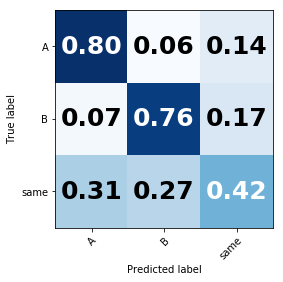

In [15]:
plot_confusion_matrix(mass_classes, np.concatenate(group_mass_prediction), MASS_CLASS_COLS, normalize=True)

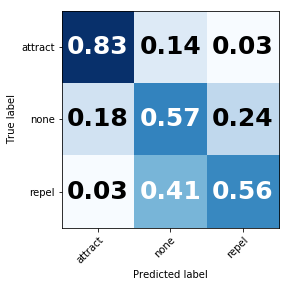

In [16]:
plot_confusion_matrix(force_classes, np.concatenate(group_force_prediction), FORCE_CLASS_COLS, normalize=True)